gmm mit experience driver
customer order
was geordert wird von customer
externe effekte

In [5]:
import importlib
import _1_Preprocessing
importlib.reload(_1_Preprocessing)

<module '_1_Preprocessing' from '/Users/canis/Library/CloudStorage/OneDrive-Persönlich/programme/coding/github/flaschenpost/_1_Preprocessing.py'>

In [6]:
import pandas as pd
from IPython.display import display
import _1_Preprocessing

df_train, df_test = _1_Preprocessing.run_preprocessing()


size before remove outliers:  (15585053, 15)
size after remove outliers:  (14329788, 15)
size after add article total weight:  (14329788, 17)


/Users/canis/Library/CloudStorage/OneDrive-Persönlich/programme/coding/github/flaschenpost/_1_Preprocessing.py:57: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  article_id_dummies = df.groupby('web_order_id')['article_id'].apply(lambda x: pd.Series(


size after one hot encoding:  (14329788, 49)
size after handle missing values:  (14329755, 49)
size after service time start ordinal encoding:  (14329755, 49)
size after train test split:  (11463804, 49) (2865951, 49)


In [7]:
pd.set_option('display.max_columns', None)
print(df_train.head())
display(df_test.head())

          warehouse_id                       order_time  has_elevator  floor  \
3699517              3        2024-11-13 11:30:00+01:00          True    0.0   
10243409            26 2024-12-19 14:46:13.207000+01:00          True    1.0   
13950199             6 2025-01-22 15:40:25.800000+01:00         False    0.0   
4405089             12 2024-12-09 08:07:32.920000+01:00         False  -10.0   
4751349             23        2024-11-22 15:15:00+01:00         False    3.0   

          is_pre_order  is_business  web_order_id  customer_id  \
3699517           True         True        198624        29208   
10243409         False         True        883833       430896   
13950199         False        False       1429436       552660   
4405089          False        False        668286       380757   
4751349           True        False        375134       604778   

          service_time_start                 service_time_end  \
3699517                   13 2024-11-13 13:31:30.040000+0

,warehouse_id,order_time,has_elevator,floor,is_pre_order,is_business,web_order_id,customer_id,service_time_start,service_time_end,service_time_in_minutes,order_datetime,driver_id,trip_id,article_id,article_weight_in_g,box_id,article_id_15043,article_id_18544,article_id_20619,article_id_21243,box_count,crate_count_1,crate_count_60,crate_count_45,crate_count_42,crate_count_41,crate_count_43,crate_count_44,crate_count_46,crate_count_47,crate_count_39,crate_count_37,crate_count_35,crate_count_38,crate_count_40,crate_count_50,crate_count_48,crate_count_36,crate_count_33,crate_count_34,crate_count_31,crate_count_52,crate_count_32,crate_count_49,crate_count_28,crate_count_30,crate_count_29,crate_count_27,num_previous_orders_customer,customer_speed
3,18,2024-12-17 09:00:00+01:00,False,0.0,True,True,806432,166859,10,2024-12-17 10:27:00.030000+01:00,17.5,2024-12-17 09:00:00+01:00,9045,133625,2574.0,164750.0,0.0,0.0,0.0,0.0,0.0,0,True,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,19.0,1.0
5,18,2024-12-17 09:00:00+01:00,False,0.0,True,True,806432,166859,10,2024-12-17 10:27:00.030000+01:00,17.5,2024-12-17 09:00:00+01:00,9045,133625,2574.0,164750.0,0.0,0.0,0.0,0.0,0.0,0,True,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,19.0,1.0
12,8,2024-12-10 09:45:00+01:00,False,0.0,True,True,678738,167463,9,2024-12-10 09:35:30.100000+01:00,9.5,2024-12-10 09:45:00+01:00,9480,111163,2841.0,148400.0,0.0,0.0,0.0,0.0,0.0,0,True,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6.0,1.0
14,8,2024-12-10 09:45:00+01:00,False,0.0,True,True,678738,167463,9,2024-12-10 09:35:30.100000+01:00,9.5,2024-12-10 09:45:00+01:00,9480,111163,3973.0,148400.0,0.0,0.0,0.0,0.0,0.0,0,True,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6.0,1.0
16,8,2024-12-10 09:45:00+01:00,False,0.0,True,True,678738,167463,9,2024-12-10 09:35:30.100000+01:00,9.5,2024-12-10 09:45:00+01:00,9480,111163,3973.0,148400.0,0.0,0.0,0.0,0.0,0.0,0,True,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6.0,1.0


In [8]:
filtered_df_train = df_train[df_train['article_id_15043'] == 1]
print(filtered_df_train)

filtered_df_train = df_train[df_train['article_id_21243'] == 1]
print(filtered_df_train)

filtered_df_train = df_train[df_train['crate_count_45'] == 1]
print(filtered_df_train)

filtered_df_train = df_train[df_train['crate_count_36'] == 1]
print(filtered_df_train)

filtered_df_train = df_train[df_train['crate_count_52'] == 1]
print(filtered_df_train)


filtered_df_train = df_train[df_train['crate_count_31'] == 1]
print(filtered_df_train)



         warehouse_id                       order_time  has_elevator  floor  \
3369806             4 2024-11-23 16:01:41.650000+01:00         False    4.0   
6861256             4        2024-11-26 09:45:00+01:00          True    3.0   
6861397             4 2024-11-18 08:19:04.777000+01:00          True    3.0   
6861277             4        2024-11-26 09:45:00+01:00          True    3.0   
6861297             4        2024-11-26 09:45:00+01:00          True    3.0   
...               ...                              ...           ...    ...   
6861383             4 2024-11-18 08:19:04.777000+01:00          True    3.0   
6861405             4 2024-11-18 08:19:04.777000+01:00          True    3.0   
3369808             4 2024-11-23 16:01:41.650000+01:00         False    4.0   
6861378             4 2024-11-18 08:19:04.777000+01:00          True    3.0   
6861271             4        2024-11-26 09:45:00+01:00          True    3.0   

         is_pre_order  is_business  web_order_id  c

In [5]:
from sklearn.linear_model import BayesianRidge
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler

# Define the list of features to keep
features_to_keep = [
    "article_weight_in_g", "is_business", "is_pre_order", "has_elevator", "floor", 
    "num_previous_orders_customer", "customer_speed"
]

# Add all columns that start with 'crate_count_' and 'article_id_'
features_to_keep += [col for col in df_train.columns if col.startswith('crate_count_')]
features_to_keep += [col for col in df_train.columns if col.startswith('article_id_')]

# Create a new dataframe with only the specified features
df_train_filtered = df_train[features_to_keep]
df_test_filtered = df_test[features_to_keep]

# Update X_train and X_test to use the filtered dataframes
X_train = df_train_filtered
X_test = df_test_filtered

# Apply StandardScaler only on continuous variables
continuous_features = [
    "article_weight_in_g", "floor", "num_previous_orders_customer", "customer_speed"
]

scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[continuous_features] = scaler.fit_transform(X_train[continuous_features])
X_test_scaled[continuous_features] = scaler.transform(X_test[continuous_features])

# Assuming 'service_time_in_minutes' is the target variable and the rest are features
X_train = X_train_scaled
y_train = df_train['service_time_in_minutes']
X_test = X_test_scaled
y_test = df_test['service_time_in_minutes']

# Initialize and train the Bayesian Ridge Regression model
model = BayesianRidge()
model.fit(X_train, y_train)

# Predict the values for the test set
y_pred = model.predict(X_test)

# Calculate and print the mean squared error
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

# Calculate and print the mean absolute error
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error: {mae}')


Mean Squared Error: 26.45291119761192
Mean Absolute Error: 3.5073328893023636


In [ ]:
# from sklearn.linear_model import BayesianRidge
# from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import mean_squared_error, mean_absolute_error

# # Define a grid of hyperparameters to search over
# param_grid = {
#     'alpha_1': [1e-6, 1e-5, 1e-4, 1e-3],
#     'alpha_2': [1e-6, 1e-5, 1e-4, 1e-3],
#     'lambda_1': [1e-6, 1e-5, 1e-4, 1e-3],
#     'lambda_2': [1e-6, 1e-5, 1e-4, 1e-3]
# }
# # Initialize the Bayesian Ridge Regression model
# model = BayesianRidge()

# # Set up GridSearchCV with 5-fold cross-validation and mean squared error scoring
# grid_search = GridSearchCV(
#     estimator=model,
#     param_grid=param_grid,
#     scoring='neg_mean_squared_error',
#     cv=5
# )

# # Fit GridSearchCV on the scaled training data (make sure to scale your features)
# grid_search.fit(X_train_scaled, y_train)

# # Output the best hyperparameters and the corresponding score
# print("Best Hyperparameters:", grid_search.best_params_)
# print("Best CV MSE:", -grid_search.best_score_)

# # Iterate over the results and print the MSE and MAE for each configuration
# for i, params in enumerate(grid_search.cv_results_['params']):
#     print(f"Configuration {i+1}: {params}")
#     mse = -grid_search.cv_results_['mean_test_score'][i]
#     print(f"Mean Squared Error: {mse}")
#     # Fit the model with the current parameters
#     model.set_params(**params)
#     model.fit(X_train_scaled, y_train)
#     y_pred = model.predict(X_test_scaled)
#     mae = mean_absolute_error(y_test, y_pred)
#     print(f"Mean Absolute Error: {mae}")

Best Hyperparameters: {'alpha_1': 1e-06, 'alpha_2': 1e-06, 'lambda_1': 1e-06, 'lambda_2': 1e-06}
Best CV MSE: 24.678890603933173


In [ ]:
print("Coefficients:", model.coef_)

Coefficients: [ 2.46797543e+00  4.76779664e-01 -1.87364902e-01  8.79573152e-01
  7.87708358e-01  5.18177544e-01  3.05974727e+00 -4.38447591e-11
 -3.31185967e-11  3.38473663e-14  3.35907987e-13  1.46283706e-14
 -4.90481212e-15  8.98364237e-15  4.18137851e-14  1.27640191e-14
  4.53580068e-14 -8.91005783e-15 -6.49486802e-16 -9.14925681e-29
 -7.25465472e-29  6.85242534e-30  5.88542913e-30  1.67104888e-30
  1.15224646e-29  2.04530778e-30  1.41316135e-32 -1.44997892e-45
  2.59678824e-45 -4.32433116e-46  3.11245603e-45 -8.19485276e-46
  9.77173446e-47  1.96717860e-46  1.65363605e+01  1.59746029e+01
  1.15845051e+00  3.57210343e-01]


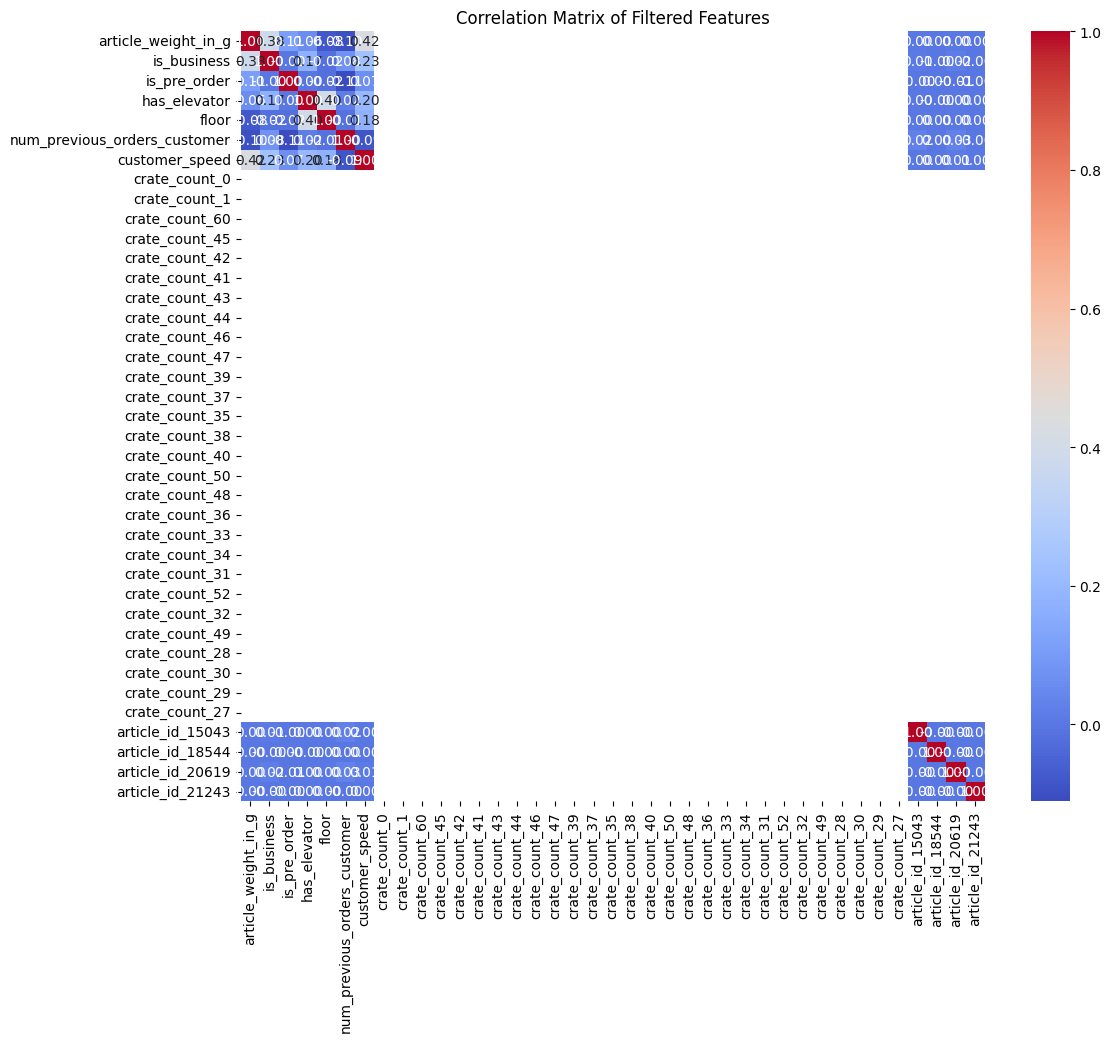

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Compute correlation matrix on your filtered dataframe
corr_matrix = df_train_filtered.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix of Filtered Features")
plt.show()

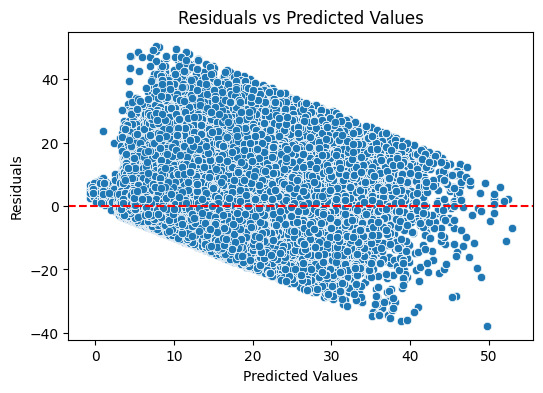

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

residuals = y_test - y_pred
plt.figure(figsize=(6,4))
sns.scatterplot(x=y_pred, y=residuals)
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted Values")
plt.axhline(0, color='red', linestyle='--')
plt.show()